In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import statsmodels.api as sm
import seaborn as sns
from collections import Counter
import scipy.stats as st
from scipy.stats import gaussian_kde

plt.style.use('default')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = 'bold'

In [2]:
os.getcwd()

'/sc/arion/projects/MetaDope/Randy/ehr'

In [3]:
os.chdir('ukbiobank/code')

In [6]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

In [63]:
#OUD

#import data for the different enrollment periods
path = '../voe_outputs/opioids/controlsLessThan3Opioids/binary_exposure/binary_outcome/controlVarOUD/'
# path = '../voe_outputs/aud/controlsNoAUDDX/binary_outcome/controlVarOUD/analyses/'

datasets = []
for enrollment_year in range(1989,2020):
    if os.path.exists(path + f'analyses/voe_{enrollment_year}_{enrollment_year+3}.csv'):
        ds = pd.read_csv(path + f'analyses/voe_{enrollment_year}_{enrollment_year+3}.csv')
        datasets.append(ds)
allexpts = pd.concat(datasets)
print(allexpts.shape)

#check for duplicate experiments
allexpts = allexpts.drop_duplicates()
print(allexpts.shape)


#start at 2004 and the last start enrollment will be 2010; low sample sizes
# no controlling for MAT or AUD based on DAG
print(allexpts.shape)
allexpts = allexpts[(allexpts.start_enroll>=2004) & (allexpts.start_enroll<=2010) &
            (allexpts['hx_MAT']==0) #& (allexpts['hx_aud']==0) 
            ]
# allexpts = allexpts[~((allexpts['hx_sud_covar']==1) & (allexpts['hx_aud']==1))]
print(allexpts.shape)
#check for duplicate experiments
allexpts = allexpts.drop_duplicates()
print(allexpts.shape)
# remove crazy confidence interval results
# allexpts = allexpts[(allexpts['.025'] > -5000) & (allexpts['.975'] < 5000)]

#add corrected p-values, OR confidence intervals, percentage of each group with NCD
if 'age_onset_ncd' not in path:
    allexpts['coef'] = np.exp(allexpts['coef'])
    allexpts['.025'] = np.exp(allexpts['.025'])
    allexpts['.975'] = np.exp(allexpts['.975'])




allexpts['bonferroni'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='bonferroni')[1]
allexpts['bh_p'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='fdr_bh')[1]
allexpts['total_N'] = allexpts['control_N'] + allexpts['opioid_N']
allexpts['opi_percent_ncd'] = 100 * (allexpts['num_opioid_ncd'] / allexpts['opioid_N'])
allexpts['con_percent_ncd'] = 100 * (allexpts['num_control_ncd'] / allexpts['control_N'])

df = allexpts.copy()


(14784, 28)
(14784, 28)
(14784, 28)
(2304, 28)
(2304, 28)


In [46]:
#AUD

#import data for the different enrollment periods
path = '../voe_outputs/aud/controlsNoAUDDX/age_onset_ncd/controlVarSUD/'
# path = '../voe_outputs/aud/controlsNoAUDDX/binary_outcome/controlVarOUD/analyses/'

datasets = []
for enrollment_year in range(1989,2020):
    if os.path.exists(path + f'analyses/voe_{enrollment_year}_{enrollment_year+3}.csv'):
        ds = pd.read_csv(path + f'analyses/voe_{enrollment_year}_{enrollment_year+3}.csv')
        datasets.append(ds)
allexpts = pd.concat(datasets)
print(allexpts.shape)

#check for duplicate experiments
allexpts = allexpts.drop_duplicates()
print(allexpts.shape)

'''
Based on the DAG, we are making the following changes:
1. Hepatitis C will not be controlled for (no path to or from opioid prescriptions)
2. History of medication-assisted therapy will not be controlled for (creates cycle in DAG)
'''

#remove 2006-2007; low sample sizes
print(allexpts.shape)
allexpts = allexpts[(allexpts.start_enroll>=2004) & (allexpts.start_enroll<=2010)]
print(allexpts.shape)

# remove crazy confidence interval results
# allexpts = allexpts[(allexpts['.025'] > -5000) & (allexpts['.975'] < 5000)]

#add corrected p-values, OR confidence intervals, percentage of each group with NCD
if 'age_onset_ncd' not in path:
    allexpts['coef'] = np.exp(allexpts['coef'])
    allexpts['.025'] = np.exp(allexpts['.025'])
    allexpts['.975'] = np.exp(allexpts['.975'])
allexpts['bonferroni'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='bonferroni')[1]
allexpts['bh_p'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='fdr_bh')[1]
allexpts['total_N'] = allexpts['control_N'] + allexpts['opioid_N']
allexpts['opi_percent_ncd'] = 100 * (allexpts['num_opioid_ncd'] / allexpts['opioid_N'])
allexpts['con_percent_ncd'] = 100 * (allexpts['num_control_ncd'] / allexpts['control_N'])

df = allexpts.copy()


(188, 23)
(188, 23)
(188, 23)
(92, 23)


NoCon -2.3595 -3.8858 -0.8333 SUD -2.5283 Smoking -1.9636 SUD_Smok -2.1196


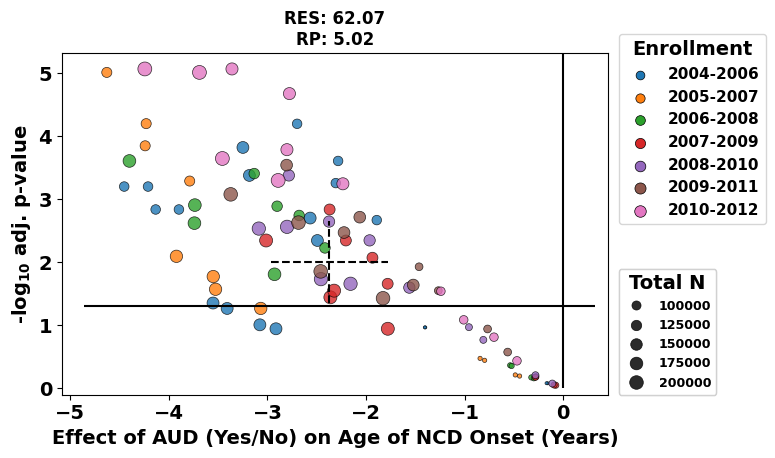

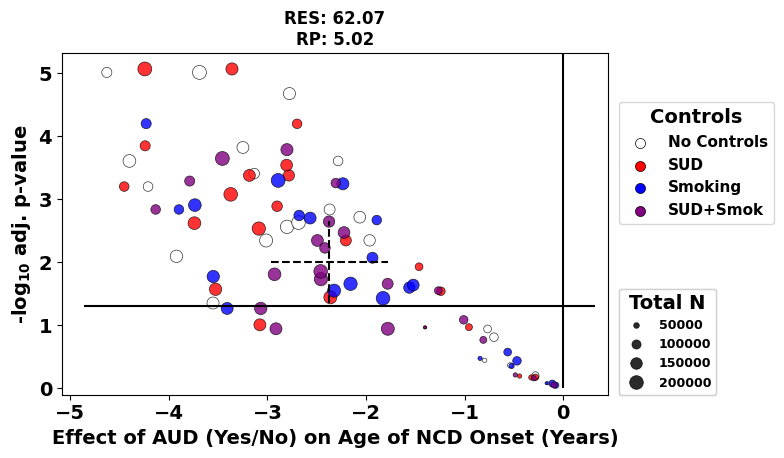

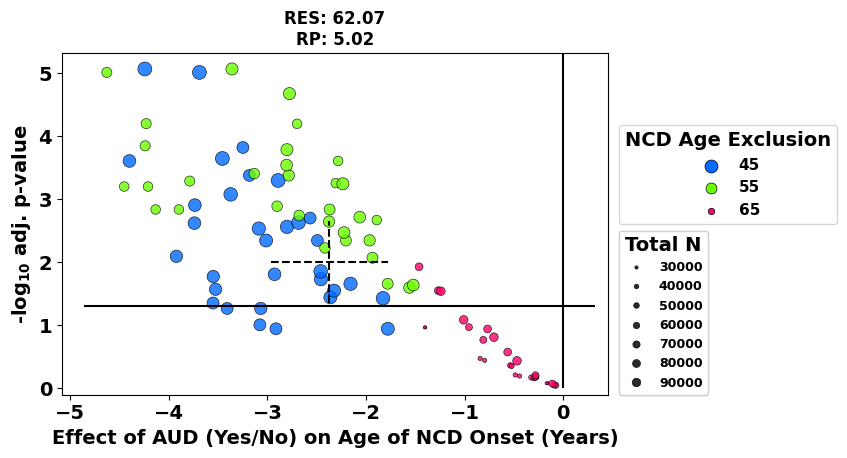

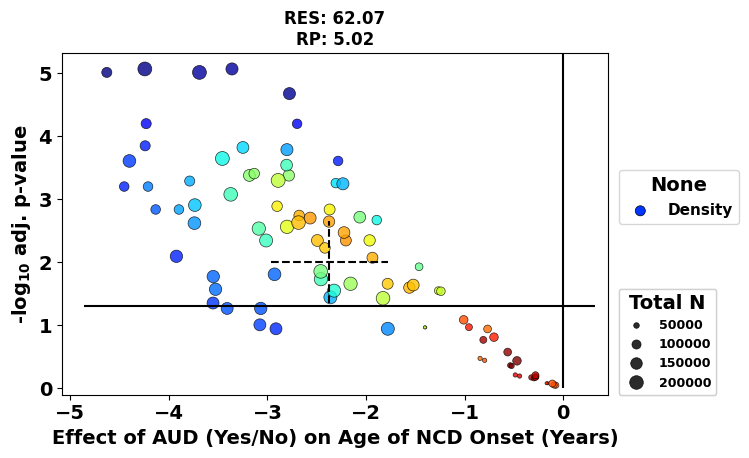

In [47]:
final_plot(df)

In [44]:
def summ_stats(coefs, pvals):
    '''Summary statistics:
    including the 1st, 50th (median), and 99th percentile of effect size and p-values
    the “relative odds ratio” (Rcoef) as the ratio of the 99th and 1st percentile odds ratio
    the “relative p-value” (RP) as the difference between the 99th and 1st percentile of -log10(adjusted p-value). '''

    #calculate relative effect size
    coefs = sorted(abs(coefs))
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    
    #calculate relative p-value    
    ps = sorted(pvals)
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)

    return rcoef, rp

def marker_scale(df):
    #min-max scale marker size based on total N of experiments for plotting and legend
    markermin = 5
    markermax = 100
    df['markerscale'] = (markermax-markermin) * ((df['total_N'] - min(df['total_N'])) / \
                                                   (max(df['total_N']) - min(df['total_N']))) + markermin
    df.markerscale = pd.to_numeric(df.markerscale)
    return df,markermin,markermax

def add_legends(df, ax, p1, legend1_label, markermin, markermax):
    #Legend colors/groups
    legend1 = ax.legend(loc=(1.02, 0.5), title=legend1_label, prop={'size': 11})
    for lh in legend1.legendHandles: 
        lh.set_alpha(1)
    ax.add_artist(legend1)

    #Legend showing sample sizes
    kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
              func=lambda s: s/(markermax-markermin) * (\
                                                      (max(df['total_N']) - min(df['total_N']))\
                                                    ) - markermin + min(df['total_N']))
    legend2 = ax.legend(*p1.legend_elements(**kw),#handles, labels,
                               loc=(1.02, 0), title="Total N", prop={'size': 9})
    ax.add_artist(legend2)
    
    
def axis_lines_labels(coefs, pvals, pcol, xlab):
    
    #vertical dotted line showing median coef
    range_pvals = max(pvals) - min(pvals)
    plt.vlines(np.median(coefs), ymin=\
                     np.median(pvals)-(0.13*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(pvals)+(0.13*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(coefs) - min(coefs))
    plt.hlines(np.median(pvals), xmin=\
                     np.median(coefs)-(0.13*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(coefs)+(0.13*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')  
    
    #axis labels
    plt.ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    plt.xlabel(xlab, fontsize=14)
    
    #mins for axis limits and axis lines
    coef_range = max(coefs) - min(coefs)
    xlim_xmin = min(coefs)-0.1*coef_range
    xlim_xmax = max(coefs)+0.1*coef_range
    hlines_xmin = min(coefs)-0.05*coef_range
    hlines_xmax = max(coefs)+0.05*coef_range
        
    #axis lines
    #if plotting odds ratios (binary outcome)
    if 'age_onset_ncd' not in path:
        if max(coefs) < 1:
            xlim_xmax = 1 + (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=1 + (0.07*coef_range), color='black')
        elif min(coefs) > 1:
            xlim_xmin = 1 - (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=1 - (0.07*coef_range), xmax=hlines_xmax, color='black')
        else:
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=hlines_xmax, color='black')
        plt.vlines(1, ymin=0, ymax=max(pvals)+0.5, color='black')

    #if plotting betas (age onset outcome)
    elif 'age_onset_ncd' in path:
        if max(coefs) < 0:
            xlim_xmax = 0 + (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=0 + (0.07*coef_range), color='black')
        elif min(coefs) > 0:
            xlim_xmin = 0 - (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=0 - (0.07*coef_range), xmax=hlines_xmax, color='black')
        else:
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=hlines_xmax, color='black')
        plt.vlines(0, ymin=0, ymax=max(pvals)+0.5, color='black')
    
    
    #axis limits
    plt.xlim((xlim_xmin, xlim_xmax))
    plt.ylim((-0.1,max(pvals)+0.05*range_pvals))

def add_title():
    #title
    res,rp = summ_stats(df.coef, -np.log10(df.bh_p))
    plt.title(f"RES: {res}\nRP: {rp}", size=12)
    
def formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab):
    #axis lines for significance and division of increased/decreased risk
    axis_lines_labels(df.coef, -np.log10(df[pcol]), pcol, xlab)
    add_legends(df, ax, p1, legend1title, markermin, markermax)
    add_title()

def plot_by_controls(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    nocon = df[(df.hx_aud==0) & (df.hx_sud_covar==0) & (df.hx_tobacco==0)]

    aud = df[(df.hx_aud==1) & (df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    sud = df[(df.hx_aud==0) & (df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    tobacco = df[(df.hx_aud==0) & (df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    
    aud_sud = df[(df.hx_aud==1) & (df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    aud_tobacco = df[(df.hx_aud==1) & (df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    sud_tobacco = df[(df.hx_aud==0) & (df.hx_sud_covar==1) & (df.hx_tobacco==1)]
    aud_sud_tobacco = df[(df.hx_aud==1) & (df.hx_sud_covar==1) & (df.hx_tobacco==1)]

    print(df.shape)
    print(nocon.shape[0]+aud.shape[0]+sud.shape[0]+tobacco.shape[0]+aud_sud.shape[0]+aud_tobacco.shape[0]+\
          sud_tobacco.shape[0]+aud_sud_tobacco.shape[0])
#     print(nocon.shape[0]+sud.shape[0])
    print('NoCon', round(np.mean(nocon.coef),4), round(np.mean(nocon['.025']),4), round(np.mean(nocon['.975']),4), 
          'AUD', round(np.mean(aud.coef),4), 
          'SUD', round(np.mean(sud.coef),4), 
          'Smoking', round(np.mean(tobacco.coef),4), 
          'AUD_SUD', round(np.mean(aud_sud.coef),4),
         'AUD_Smok', round(np.mean(aud_tobacco.coef),4), 
          'SUD_Smok', round(np.mean(sud_tobacco.coef),4), 
          'All', round(np.mean(aud_sud_tobacco.coef),4)
                      )
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([nocon, sud, tobacco, aud, sud_tobacco, aud_sud, aud_tobacco, aud_sud_tobacco],
                          ['No Controls','OUD','Smoking','AUD','OUD+Smok','OUD+AUD', 'Smok+AUD',  'All'],
                          ['white',      'red','yellow','blue','orange', 'purple', 'green',  'black']
                         ):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                        edgecolor='k', linewidth=0.5,label=lab,c=col)
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    
def aud_plot_by_controls(df, pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    nocon = df[(df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    aud = df[(df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    sud = df[(df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    tobacco = df[(df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    
    aud_sud = df[(df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    aud_tobacco = df[(df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    sud_tobacco = df[(df.hx_sud_covar==1) & (df.hx_tobacco==1)]
    aud_sud_tobacco = df[(df.hx_sud_covar==1) & (df.hx_tobacco==1)]

    print('NoCon', round(np.mean(nocon.coef),4), round(np.mean(nocon['.025']),4), round(np.mean(nocon['.975']),4), 
          'SUD', round(np.mean(sud.coef),4), 
          'Smoking', round(np.mean(tobacco.coef),4), 
          'SUD_Smok', round(np.mean(sud_tobacco.coef),4), 
                      )
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([nocon, sud, tobacco, sud_tobacco,],
                          ['No Controls','SUD','Smoking','SUD+Smok'],
                          ['white',      'red','blue','purple']
                         ):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                        edgecolor='k', linewidth=0.5,label=lab,c=col)
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    

def plot_by_opioid_enroll(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    op5 = df[(df.opioid_rx_enroll==5)]
    op10 = df[(df.opioid_rx_enroll==10)]
    op15 = df[(df.opioid_rx_enroll==15)]

    fig, ax = plt.subplots()
    for ds,lab,col in zip([op5, op10, op15],['5 Rx','10 Rx','15 Rx'], ['#00FF59','#FF5900','#5900FF']):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, c=col,
                        edgecolor='k', linewidth=0.5, s=ds['markerscale'].values, label=lab)
        
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    
def plot_by_ncd_age_exclusion(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)

    age45 = df[(df.ncd_age_threshold==45)]
    age55 = df[(df.ncd_age_threshold==55)]
    age65 = df[(df.ncd_age_threshold==65)]
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([age45,age55,age65], ['45','55','65'], ['#0069FF','#69FF00','#FF0069']):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha,
                        s=ds['markerscale'].values, edgecolor='k', linewidth=0.5, label=lab, c=col)

    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)    
    
def plot_by_enroll_year(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)

    enroll_years = sorted(list(set(df.start_enroll)))
    
    #plot each year's data in a loop
    fig, ax = plt.subplots()
    for ey in enroll_years:
        ey_df = df[(df.start_enroll==ey)]
        p1 = ax.scatter(ey_df.coef, -np.log10(ey_df[pcol]), alpha=alpha,
                        s=[float(x) for x in ey_df['markerscale'].values], edgecolor='k', linewidth=0.5,
                        label=f'{str(ey)}-{str(ey+2)}')
        
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
        
        
def density_plot(df, pcol, legend1title, xlab, alpha):
    
    df,markermin,markermax = marker_scale(df)
    
    # set x,y data
    x = df.coef
    y = -np.log10(df[pcol])

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    p1 = ax.scatter(x, y, alpha=alpha, c=z, cmap=plt.cm.jet,s=df['markerscale'].values, edgecolor='k', linewidth=0.5,
                        label='Density')
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)


def final_plot(df):
    if 'opioids/controlsLessThan3Opioids/prescription_count/binary_outcome/' in path:
        df = df[df.coef>0.99]


    if 'binary_exposure' in path:
        predictor = 'binaryExposure'
        if 'age_onset_ncd' in  path:
            outcome = 'ageOnsetNCD'
            xlab = 'Effect of OPRx (Yes/No) on Age of NCD Onset (Years)'#binary exposure, age of onset

        elif 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = 'Effect of OPRx (Yes/No) on Odds Ratio' #binary exposure, binary outcome
            
    elif 'prescription_count' in path:
        predictor = 'prescriptionCount'
        if 'age_onset_ncd' in  path:
            outcome = 'ageOnsetNCD'
            xlab = r'Effect of Individual OPRx on Age of NCD Onset (Years)' #prescription count, age of onset
        elif 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = r'Effect of Individual OPRx on Odds Ratio' #prescription count, binary outcome
    else:
        predictor = ''
        if 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = 'Effect of AUD (Yes/No) on Odds Ratio'
        elif 'age_onset_ncd' in path:
            outcome = 'ageOnsetNCD'
            xlab = 'Effect of AUD (Yes/No) on Age of NCD Onset (Years)'


    if '/aud/' in path:
        drug = 'AUD'
        alpha = 0.8
    else:
        drug = ''
        alpha = 0.2
        
    pcol = 'bh_p'

    colorby='enrollYear'
    plot_by_enroll_year(df,pcol,'Enrollment', xlab, alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='controlVars'
    if '/aud/' not in path:
        plot_by_controls(df,pcol,'Controls',xlab,alpha)
    else:
        aud_plot_by_controls(df,pcol,'Controls',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    if '/aud/' not in path:
        colorby='OPRxEnroll'
        plot_by_opioid_enroll(df,pcol,'OPRx Enrollment', xlab,alpha)
        plt.tight_layout()
        plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='NCDAgeExclusion'
    plot_by_ncd_age_exclusion(df,pcol,'NCD Age Exclusion',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='Density'
    density_plot(df,pcol,'None',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)


In [17]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

In [28]:
five = df[(df.followup_time==5)]
ten = df[(df.followup_time==10)]
direct = df[(df.hx_sud_covar==1)]
total = df[(df.hx_sud_covar==0)]
correct = df[(df.hx_aud==0) & (df.hx_sud_covar==0) & (df.hx_MAT==0)]

In [31]:
df.shape, df[df.hx_MAT==1].shape

((2304, 33), (0, 33))

In [31]:
enroll_years = sorted(list(set(allexpts.start_enroll)))
print('year ','min_opi ','max_opi ','min_con ','max_con ','min_tot ','max_tot ', 'opi_ncd')
for ey in enroll_years:
    
    print(ey, '  ',
         np.min(allexpts[allexpts.start_enroll==ey]['opioid_N']), '  ',
         np.max(allexpts[allexpts.start_enroll==ey]['opioid_N']),'  ',
         np.min(allexpts[allexpts.start_enroll==ey]['control_N']), '  ',
         np.max(allexpts[allexpts.start_enroll==ey]['control_N']),'  ',
         np.min(allexpts[allexpts.start_enroll==ey]['total_N']), '  ',
         np.max(allexpts[allexpts.start_enroll==ey]['total_N']), '  ',
         np.min(allexpts[allexpts.start_enroll==ey]['num_opioid_ncd']))

year  min_opi  max_opi  min_con  max_con  min_tot  max_tot  opi_ncd
2004    425    4921    16174    136948    16599    141869    4
2005    600    5262    24704    145248    25304    150510    8
2006    847    5811    32355    151721    33202    157532    11
2007    1161    6415    41459    158002    42620    164417    17
2008    1500    7018    49586    164372    51086    171390    25
2009    1903    7753    59654    170970    61557    178723    30
2010    2282    8423    71227    178117    73509    186540    36


In [19]:
print('min_opi ','max_opi ','min_con ','max_con ','min_tot ','max_tot ', 'opi_ncd')

print(
    np.min(allexpts['opioid_N']), '   ',
    np.max(allexpts['opioid_N']),'   ',
    np.min(allexpts['control_N']), '   ',
    np.max(allexpts['control_N']),'   ',
    np.min(allexpts['total_N']), '   ',
    np.max(allexpts['total_N']), '   ',
    np.min(allexpts['num_opioid_ncd']),'\n',
    'control male %', np.min(allexpts['control_male%']),
    np.max(allexpts['control_male%']),'\n',
    'control female %', np.min(allexpts['control_female%']),
    np.max(allexpts['control_female%']),'\n',
    'opioid male %', np.min(allexpts['opioid_male%']),
    np.max(allexpts['opioid_male%']),'\n',
    'opioid female %', np.min(allexpts['opioid_female%']),
    np.max(allexpts['opioid_female%']),'\n',
    'opioid mean age', np.min(allexpts['opioid_AgeMean']),
    np.max(allexpts['opioid_AgeMean']),'\n',
    'control mean age', np.min(allexpts['control_AgeMean']),
    np.max(allexpts['control_AgeMean']),'\n',
         )

min_opi  max_opi  min_con  max_con  min_tot  max_tot  opi_ncd
425     8423     16174     178117     16599     186540     4 
 control male % 0.4306379063586179 0.5014371812702828 
 control female % 0.4985628187297172 0.5693620936413821 
 opioid male % 0.4015444015444015 0.4376470588235294 
 opioid female % 0.5623529411764706 0.5984555984555985 
 opioid mean age 59.80722367275892 69.83922219587384 
 control mean age 58.06838359040869 69.59721734735423 



In [12]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

In [73]:
print(min(allexpts.opioid_N), max(allexpts.opioid_N),
     min(allexpts.control_N), max(allexpts.control_N),
     min(allexpts.total_N), max(allexpts.total_N),)

427 8426 16936 188017 17363 196443


In [38]:
allexpts.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

# Histogram of opioid prescriptions in opioid-exposed population in time common with UKB

In [48]:
pop = pd.read_csv('../voe_outputs/opioids/controlsLessThan3Opioids/binary_exposure/binary_outcome/controlVarOUD/populations/voe_2010_2013_5yearfollowup_5OpioidsEnrollment_45NCDageExclusion.csv')

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


([], [])

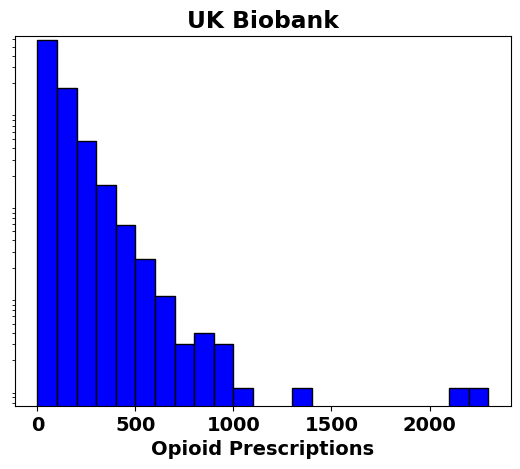

In [62]:
plt.hist(pop[pop.label==1].opioid_count, log=True, color='blue', edgecolor='k', bins=np.arange(0,2400,100))
plt.title('UK Biobank')
plt.xlabel('Opioid Prescriptions')
plt.ylabel('')
plt.ylim((0,6500))
plt.yticks(())

1.0


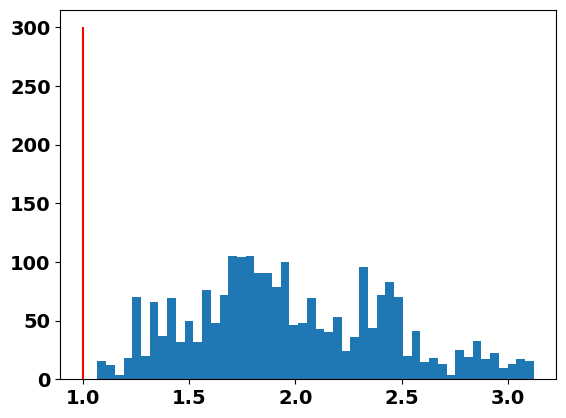

In [74]:
plt.hist(df.coef, bins=50,)

if 'age_onset' in path:
    print(df[df.coef<0].shape[0] / df.shape[0])
    plt.vlines(0, 0, 300, color='red')
else:
    print(df[df.coef>1].shape[0] / df.shape[0])
    plt.vlines(1, 0, 300, color='red')


In [75]:
ci = st.t.interval(alpha=0.95, df=df.shape[0]-1, loc=np.mean(df.coef), scale=st.sem(df.coef)) 
np.mean(df.coef), ci

(1.97659778971473, (1.9577498706613836, 1.9954457087680764))

In [41]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

0.7986111111111112


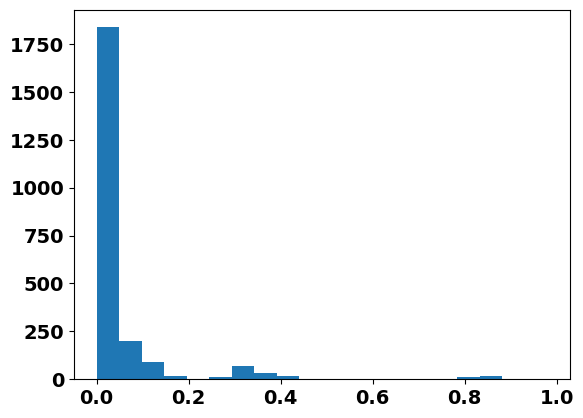

In [76]:
# df2 = df[df.start_enroll>=2006]

plt.hist(df.bh_p, bins=np.arange(0,1,0.049))
print(df[df.bh_p<0.05].shape[0] / df.shape[0])

0.3967013888888889


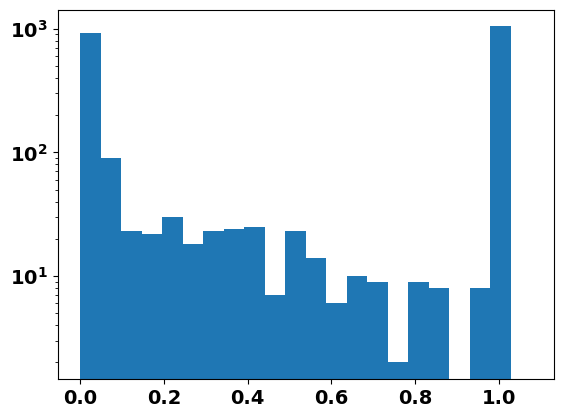

In [77]:
plt.hist(df.bonferroni, bins=np.arange(0,1.1,0.049), log=True)
print(df[df.bonferroni<0.05].shape[0] / df.shape[0])

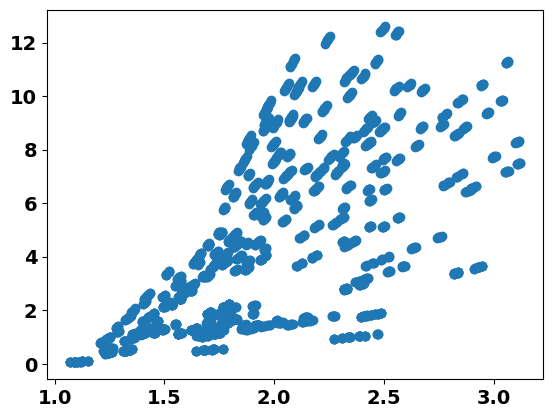

In [78]:
plt.scatter(df.coef, -np.log10(df.p))

In [96]:
nonsig = df[df.bh_p>=0.05]
sig = df[df.bh_p<0.05]

In [97]:
nonsig.start_enroll.value_counts()

2004    376
2003    260
2008     64
2006     40
2007     32
2009     32
Name: start_enroll, dtype: int64

In [98]:
sig.start_enroll.value_counts()

2005    288
2007    256
2009    256
2006    248
2008    224
2003    220
2004    200
Name: start_enroll, dtype: int64

# Loop through all individual control variables

In [22]:
def loop_controls(df,controlvars,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    for cv in controlvars:
        cv_df = df[df[cv]==1]
        con_df = df[df[cv]==0]

        fig, ax = plt.subplots()
        for ds,lab,col in zip([con_df,cv_df],
                              ['No Controls',cv],
                              ['blue','red']
                             ):
            p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                            edgecolor='k', linewidth=0.5,label=lab,c=col)
        formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)

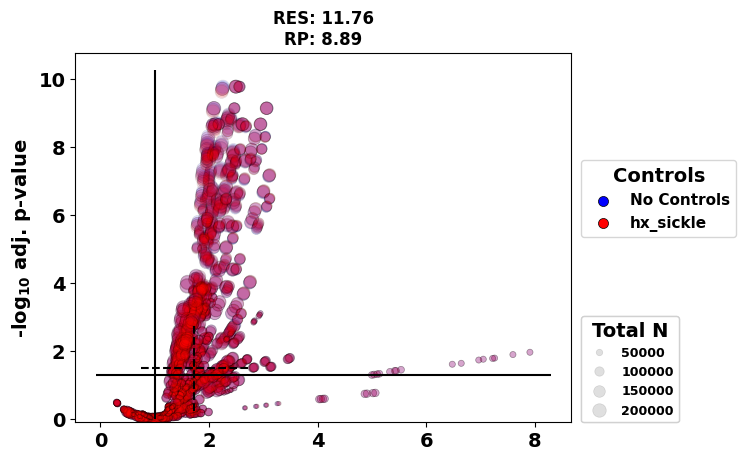

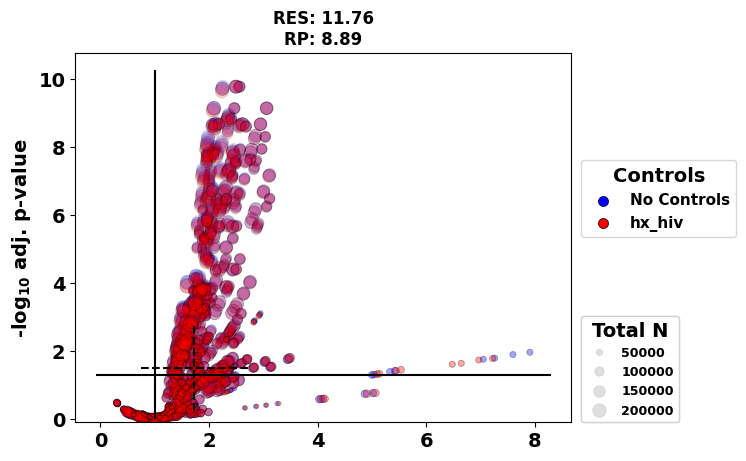

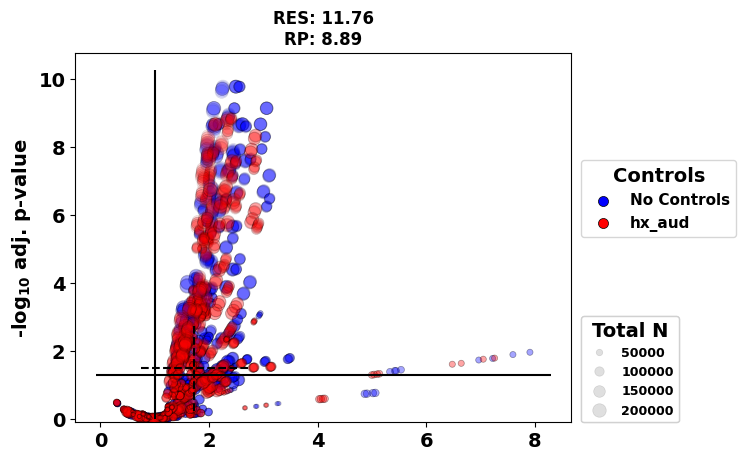

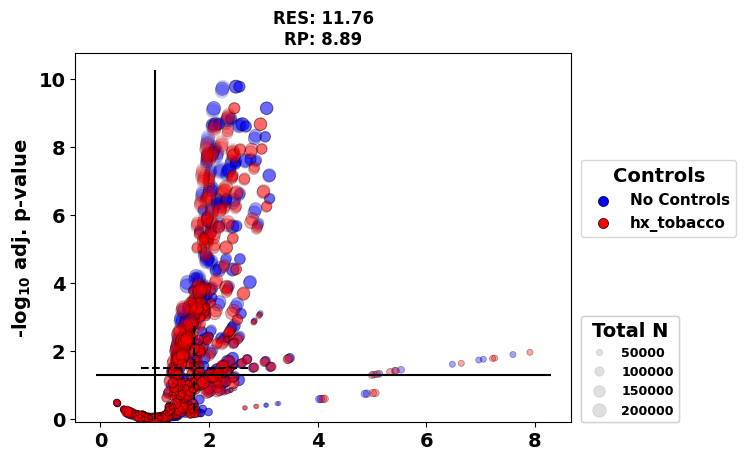

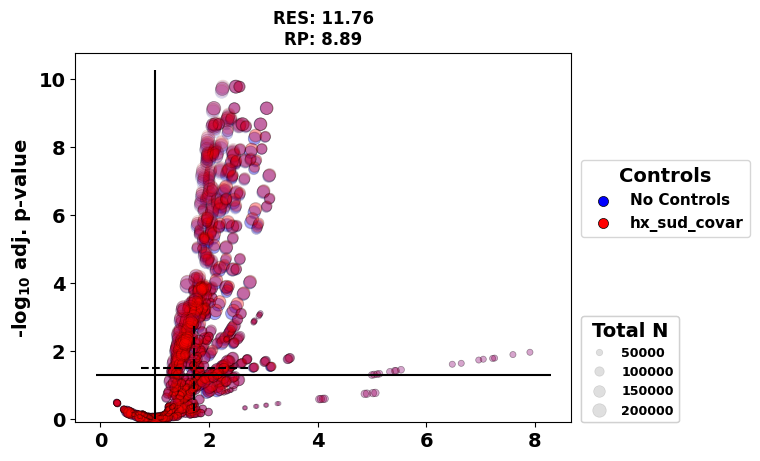

In [24]:
xlab = ''
alpha=0.1
controlvars = ['hx_sickle','hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar']

loop_controls(df,controlvars,'bh_p','Controls',xlab,alpha)

In [3]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

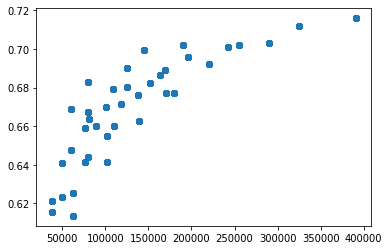

In [60]:
plt.scatter(allexpts['total_N'], allexpts['opioid_male%'])

In [20]:
from sklearn.preprocessing import MinMaxScaler


# cols=['OR','p', 'hx_sud_opioid_enroll', 'hx_sickle', 'hx_hepc', 'hx_hiv', 'hx_aud',
#        'hx_sud_covar', 'num_recs_covar']
# sns.heatmap(resy[cols])

resy=allexpts
df = pd.DataFrame()

# scaler = MinMaxScaler()
# df = scaler.fit_transform(resy)
# df = pd.DataFrame(df)
# df.columns = resy.columns


for col in resy.columns: #['OR','p','hx_sud_covar',]:

#[c for c in resy.columns if c not in ['start_enroll', 'end_enroll', 'num_opioid_ncd', 'opi_percent_ncd']]:
    print(col)
    col_zscore = col
    df[col_zscore] = (resy[col] - resy[col].mean())/resy[col].std(ddof=0) #zscore
    #df[col_zscore] = (resy[col] - min(resy[col])/(max(resy[col]) - min(resy[col]))) #minmax
    
df.sort_values('p', inplace=True)
# f, ax = plt.subplots(figsize=(10, 5))
ax = sns.clustermap(df.drop(columns=['start_enroll','end_enroll']), cmap='seismic')
# ax.set_yticks(())


control_N
opioid_N
control_AgeMean
control_AgeSD
opioid_AgeMean
opioid_AgeSD
control_male%
control_female%
opioid_male%
opioid_female%
coef
stderr
.025
.975
p
num_control_ncd
num_opioid_ncd
followup_time
start_enroll
end_enroll
opioid_rx_enroll
ncd_age_threshold
hx_sickle
hx_hiv
hx_aud
hx_tobacco
hx_sud_covar
hx_MAT


ZeroDivisionError: float division by zero

(array([192., 160., 320.,  64., 256.,  96., 160., 128.,  96., 128.,  96.,
         96.,  32.,  64.,   0., 192.,   0.,  96.,  32.,   0.,  64.,   0.,
          0.,   0.,  96.,   0.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,
         64.,   0.,   0.,   0.,  32.,   0.,  32.,   0.,   0.,   0.,   0.,
         32.,   0.,   0.,   0.,   0.,  32.]),
 array([ 147.  ,  336.78,  526.56,  716.34,  906.12, 1095.9 , 1285.68,
        1475.46, 1665.24, 1855.02, 2044.8 , 2234.58, 2424.36, 2614.14,
        2803.92, 2993.7 , 3183.48, 3373.26, 3563.04, 3752.82, 3942.6 ,
        4132.38, 4322.16, 4511.94, 4701.72, 4891.5 , 5081.28, 5271.06,
        5460.84, 5650.62, 5840.4 , 6030.18, 6219.96, 6409.74, 6599.52,
        6789.3 , 6979.08, 7168.86, 7358.64, 7548.42, 7738.2 , 7927.98,
        8117.76, 8307.54, 8497.32, 8687.1 , 8876.88, 9066.66, 9256.44,
        9446.22, 9636.  ]),
 <BarContainer object of 50 artists>)

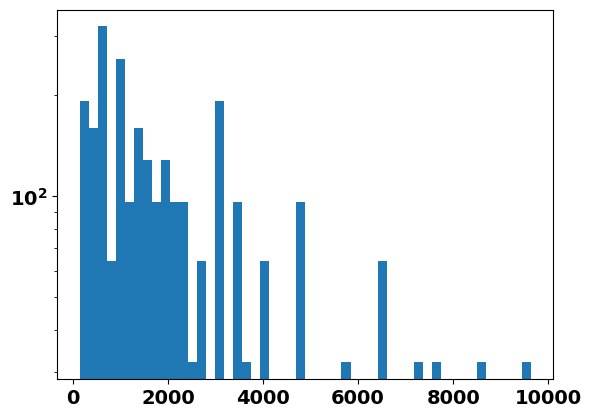

In [34]:
plt.hist(allexpts.opioid_N,bins=50,log=True)

In [35]:
#preprocess data before plotting
res = allexpts.copy()

res = res.sort_values('coef')
res.reset_index(drop=True, inplace=True)



In [54]:
def plot_by_controls(r,panel):
    #plot experiments separately fcoef each set of controls (None, SUD only, AUD only)
    noCon = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0) ]
    conSud = r[(r['hx_sud_covar']==1) & (r['hx_aud']==0)]
    conAud = r[(r['hx_sud_covar']==0) & (r['hx_aud']==1)]
    conDepression = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0) ]
    
    #No controls
    p1 = ax[panel].scatter(noCon.coef, -np.log10(noCon[p_col]), c='#FF0006',
                    s=noCon['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='Neither'#5
                          )
    #Control AUD only
    p2 = ax[panel].scatter(conAud.coef, -np.log10(conAud[p_col]), c='#0006FF',
                    s=conAud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='AUD'#10#
                          )
    #Control SUD only
    p3 = ax[panel].scatter(conSud.coef, -np.log10(conSud[p_col]), c='#06FF00',
                    s=conSud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='SUD'#15#
                          )
    
    if panel==(0,6):
        #Legend fcoef colors/groups
        legend1 = ax[panel].legend(loc=(1.02, 0.5), title='Controls', prop={'size': 11})
        ax[panel].add_artist(legend1)
        
        #Legend showing sample sizes
        kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
                  func=lambda s: s/(markermax-markermin) * (\
                                                          (max(r['total_N']) - min(r['total_N']))\
                                                        ) - markermin + min(r['total_N']))
        legend2 = ax[panel].legend(*p1.legend_elements(**kw),#handles, labels,
                                   loc=(1.02, 0), title="N", prop={'size': 9})
        
    return p1

def plot_by_opioid_rx_enroll(r,panel):
    #plot experiments separately fcoef each opioid exposure criterion (5, 10, coef 15 prescriptions)
    five = r[(r['opioid_rx_enroll']==5)]
    ten = r[(r['opioid_rx_enroll']==10)]  
    fifteen = r[(r['opioid_rx_enroll']==15)]
    
    #5 opioid Rx
    p1 = ax[panel].scatter(five.coef, -np.log10(five[p_col]), c='#FF0006',
                    s=five['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='5'
                          )
    #10 opioid Rx
    p2 = ax[panel].scatter(ten.coef, -np.log10(ten[p_col]), c='#0006FF',
                    s=ten['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='10'
                          )
    #15 opioid Rx
    p3 = ax[panel].scatter(fifteen.coef, -np.log10(fifteen[p_col]), c='#06FF00',
                    s=fifteen['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='15'
                          )
    if panel==(0,6):
        #Legend fcoef colors/groups
        legend1 = ax[panel].legend(loc=(1.02, 0.5), title='Opioid Rx', prop={'size': 11})
        ax[panel].add_artist(legend1)
        
        #Legend showing sample sizes
        kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
                  func=lambda s: s/(markermax-markermin) * (\
                                                          (max(r['total_N']) - min(r['total_N']))\
                                                        ) - markermin + min(r['total_N']))
        legend2 = ax[panel].legend(*p1.legend_elements(**kw),#handles, labels,
                                   loc=(1.02, 0), title="N", prop={'size': 9})
    
    return p1

In [55]:
def plot_results(r, panel, fu, plotby='controls'):
    
    #solid lines denoting increased/decreased odds and statistical significance
    ax[panel].hlines(-np.log10(0.05),xmin=1-(0.25*max(r.coef)),#0.5,#
                     xmax=max(r['.975']),#8,#
                     color='black')
    ax[panel].vlines(1.0, ymin=-0.5, ymax=-np.log10(min(r[p_col])),#34,#
                     color='black')

    #vertical dotted line showing median coef
    range_pvals = (max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))
    ax[panel].vlines(np.median(r.coef), ymin=\
                     np.median(-np.log10(r[p_col]))-(0.3*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(-np.log10(r[p_col]))+(0.3*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(r['.975']) - min(r['.025']))
    ax[panel].hlines(np.median(-np.log10(r[p_col])), xmin=\
                     np.median(r.coef)-(0.3*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(r.coef)+(0.3*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')    

#     ax[panel].set_xlim((0,8.5))
#     ax[panel].set_ylim((-1,35))
    
    #print median coef, median p, mean control age, mean opioid age
#     print(f'50% coef: {np.median(r.coef)}')
#     print(f'50% p: {np.median(r.bh_p)}')
#     print(f'mean control age: {np.mean(r.control_AgeMean)}')
#     print(f'mean opioid age: {np.mean(r.opioid_AgeMean)}')
#     print('\n')

    if plotby=='controls':
        p1=plot_by_controls(r,panel)
    elif plotby=='opioid_rx_enroll':
        p1=plot_by_opioid_rx_enroll(r,panel)
    
    #Axis labels
    if panel[1]==0:
        ax[panel].set_ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    if panel[0]==1:
        ax[panel].set_xlabel('Odds Ratio', fontsize=14)
    
    #error bar start and stop points based on confidence interval of coef
    lower_error = abs(r.coef-r['.025'])
    higher_error = abs(r.coef-r['.975'])
    ax[panel].errorbar(r.coef, -np.log10(r[p_col]), xerr=[lower_error, higher_error],
                 alpha=0.2, color='k', linewidth=0.1, ls='none')
    
    #calculate relative odds ratio
    coefs = sorted(r.coef)
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    #calculate relative p-value    
    ps = sorted(-np.log10(r.bh_p))
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)
    
    #Title of plot with enrollment period, follow-up time, relative coef and relative p-value
    ax[panel].set_title(
        f"{r.start_enroll.values[0]}-{r.end_enroll.values[0]-1}, {fu}y followup\nROR: {rcoef}\nRP: {rp}",
            size=12)


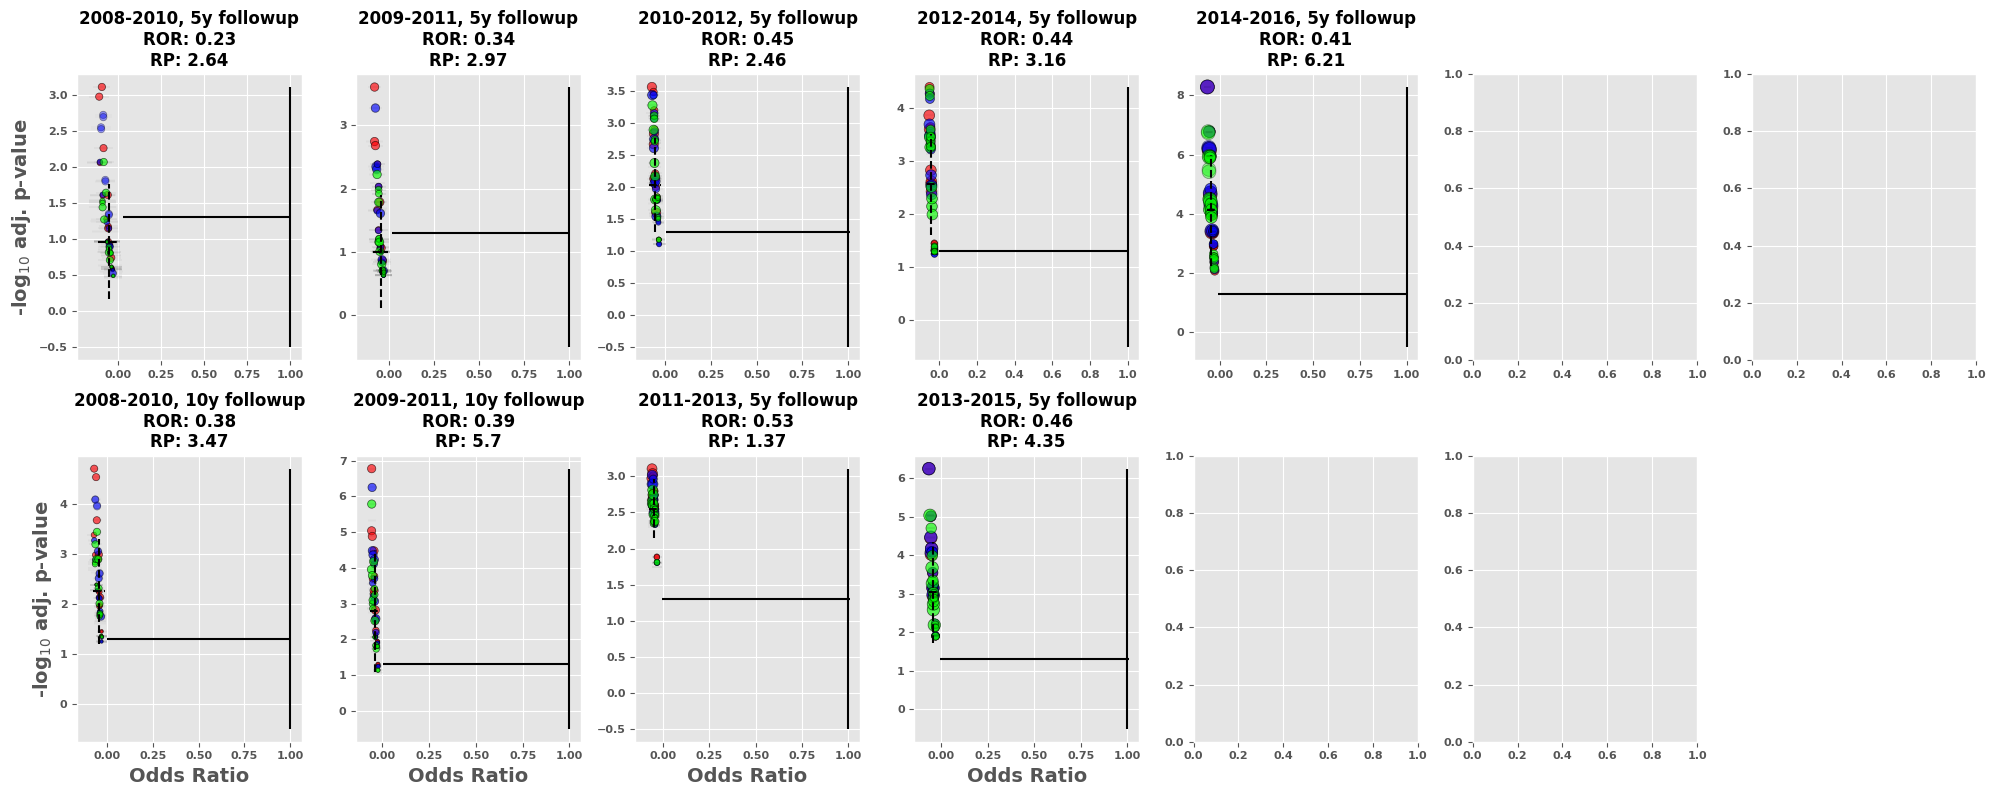

In [57]:
#plot and color based on follow-up time and controlling for SUD
plt.style.use('default')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = 'bold'
cmap = sns.color_palette("icefire", as_cmap=True)

#Five plots:
#2006-2009, 5y/10y followup
#2009-2012, 5y/10y followup
#2012-2015, 5y followup

#2 rows, 3 columns of plots
f, ax = plt.subplots(nrows=2, ncols=7, figsize=(20,8))
f.delaxes(ax[1,6])

#min-max scale marker size based on total N of experiments for plotting and legend
markermin = 5
markermax = 100
res = allexpts
res['markerscale'] = (markermax-markermin) * ((res['total_N'] - min(res['total_N'])) / \
                                               (max(res['total_N']) - min(res['total_N']))) + markermin
alpha=0.4
edgecolor='black'
p_col = 'bh_p'
   
#subset data for each plot
ds_plot = []
ax_row = 0
ax_col = 0
for ey in [2008,2009,2010,2011,2012,2013,2014]:
    for fut in [5,10]:
        if ey>2009 and fut==10:
            continue
        ds = res[(res.start_enroll==ey) & (res.followup_time==fut) \
                # & (res.hx_depression==0) & (res.hx_anxiety==0)
                ]
                 #(res.opioid_rx_enroll>10)]
        
        ds_plot.append((ds,(ax_row,ax_col),fut))
        
        if ax_row==0:
            ax_row+=1
        else:
            ax_col+=1
            ax_row=0
        
plotby='controls'
for i,ds in enumerate(ds_plot):
#     print(np.mean(ds[0].total_N))
    plot_results(ds[0], ds[1], ds[2], plotby=plotby)

plt.tight_layout()
# plt.savefig('../figures/binaryNCDOutcome_binaryOpioidExposure_sameScale.png', dpi=300)

In [60]:
#AGE OF ONSET
def plot_results(r, panel, fu, plotby='controls'):
    
    #solid lines denoting increased/decreased odds and statistical significance
    ax[panel].hlines(-np.log10(0.05),xmin=0-(0.25*max(r.coef)),#0.5,#
                     xmax=max(r['.975']),#8,#
                     color='black')
    ax[panel].vlines(0, ymin=-0.5, ymax=-np.log10(min(r[p_col])),#34,#
                     color='black')

    #vertical dotted line showing median coef
    range_pvals = (max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))
    ax[panel].vlines(np.median(r.coef), ymin=\
                     np.median(-np.log10(r[p_col]))-(0.3*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(-np.log10(r[p_col]))+(0.3*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(r['.975']) - min(r['.025']))
    ax[panel].hlines(np.median(-np.log10(r[p_col])), xmin=\
                     np.median(r.coef)-(0.3*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(r.coef)+(0.3*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')    

#     ax[panel].set_xlim((0,8.5))
#     ax[panel].set_ylim((-1,35))
    
    #print median coef, median p, mean control age, mean opioid age
#     print(f'50% coef: {np.median(r.coef)}')
#     print(f'50% p: {np.median(r.bh_p)}')
#     print(f'mean control age: {np.mean(r.control_AgeMean)}')
#     print(f'mean opioid age: {np.mean(r.opioid_AgeMean)}')
#     print('\n')

    if plotby=='controls':
        p1=plot_by_controls(r,panel)
    elif plotby=='opioid_rx_enroll':
        p1=plot_by_opioid_rx_enroll(r,panel)
    
    #Axis labels
    if panel[1]==0:
        ax[panel].set_ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    if panel[0]==1:
        ax[panel].set_xlabel('Odds Ratio', fontsize=14)
    
    #error bar start and stop points based on confidence interval of coef
    lower_error = abs(r.coef-r['.025'])
    higher_error = abs(r.coef-r['.975'])
    ax[panel].errorbar(r.coef, -np.log10(r[p_col]), xerr=[lower_error, higher_error],
                 alpha=0.2, color='k', linewidth=0.1, ls='none')
    
    #calculate relative odds ratio
    coefs = sorted(r.coef)
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    #calculate relative p-value    
    ps = sorted(-np.log10(r.bh_p))
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)
    
    #Title of plot with enrollment period, follow-up time, relative coef and relative p-value
    ax[panel].set_title(
        f"{r.start_enroll.values[0]}-{r.end_enroll.values[0]-1}, {fu}y followup\nROR: {rcoef}\nRP: {rp}",
            size=12)


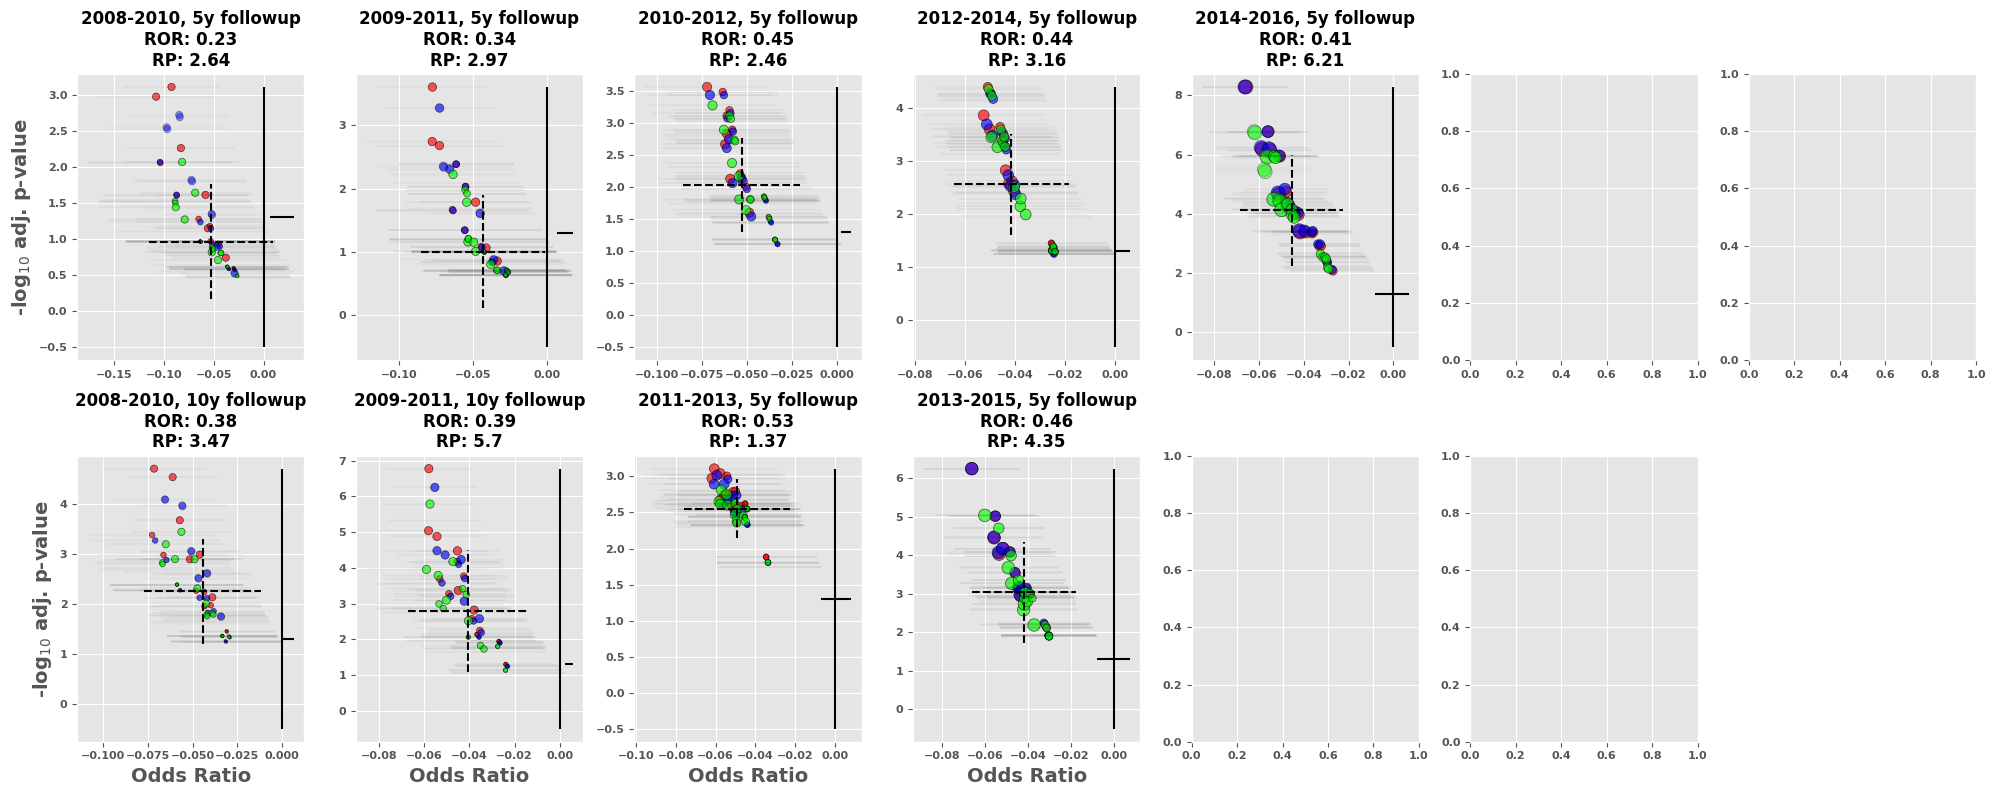

In [61]:
#AGE OF ONSET
#plot and color based on follow-up time and controlling for SUD
plt.style.use('default')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = 'bold'
cmap = sns.color_palette("icefire", as_cmap=True)

#Five plots:
#2006-2009, 5y/10y followup
#2009-2012, 5y/10y followup
#2012-2015, 5y followup

#2 rows, 3 columns of plots
f, ax = plt.subplots(nrows=2, ncols=7, figsize=(20,8))
f.delaxes(ax[1,6])

#min-max scale marker size based on total N of experiments for plotting and legend
markermin = 5
markermax = 100
res = allexpts
res['markerscale'] = (markermax-markermin) * ((res['total_N'] - min(res['total_N'])) / \
                                               (max(res['total_N']) - min(res['total_N']))) + markermin
alpha=0.4
edgecolor='black'
p_col = 'bh_p'
   
#subset data for each plot
ds_plot = []
ax_row = 0
ax_col = 0
for ey in [2008,2009,2010,2011,2012,2013,2014]:
    for fut in [5,10]:
        if ey>2009 and fut==10:
            continue
        ds = res[(res.start_enroll==ey) & (res.followup_time==fut) \
                # & (res.hx_depression==0) & (res.hx_anxiety==0)
                ]
                 #(res.opioid_rx_enroll>10)]
        
        ds_plot.append((ds,(ax_row,ax_col),fut))
        
        if ax_row==0:
            ax_row+=1
        else:
            ax_col+=1
            ax_row=0
        
plotby='controls'
for i,ds in enumerate(ds_plot):
#     print(np.mean(ds[0].total_N))
    plot_results(ds[0], ds[1], ds[2], plotby=plotby)

plt.tight_layout()
# plt.savefig('../figures/binaryNCDOutcome_binaryOpioidExposure_sameScale.png', dpi=300)

In [192]:
ds[0].loc[:,['.025','.975','coef']].head()

,.025,.975,coef
0,1.959241,2.514997,2.219794
1,1.909864,2.477361,2.175183
2,1.924947,2.525961,2.205072
3,1.890546,2.494988,2.171840
4,1.969198,2.532393,2.233111


In [73]:
np.mean(noanxdep.OR)

1.012031537905799

In [129]:
allexpts[(allexpts.hx_depression==0) & (allexpts.hx_anxiety==0) & (allexpts.start_enroll>2007) & \
        (allexpts.opioid_rx_enroll==5)].shape

(1101, 34)

In [54]:
print(np.mean(res[res.opioid_rx_enroll==5].total_N),
     np.mean(res[res.opioid_rx_enroll==10].total_N),
     np.mean(res[res.opioid_rx_enroll==15].total_N))

86202.2 85613.2 80408.2864321608


In [34]:
len(ds_plot)

6

0.03175649499161768


(array([ 78., 242., 377., 407., 295., 243., 155., 103.,  68.,  48.]),
 array([1.04757512, 1.12314762, 1.19872011, 1.27429261, 1.3498651 ,
        1.42543759, 1.50101009, 1.57658258, 1.65215508, 1.72772757,
        1.80330006]),
 <BarContainer object of 10 artists>)

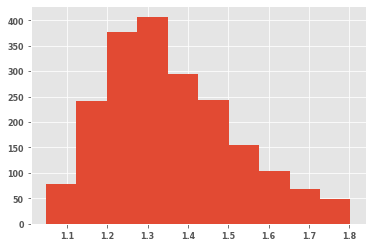

In [140]:
df = res[res.hx_depression==1]
print(np.mean(df.p))
plt.hist(df.OR)

5.258706934342401e-05


(array([128., 338., 413., 473., 192., 174., 107.,  75.,  65.,  51.]),
 array([1.27318674, 1.4347088 , 1.59623085, 1.75775291, 1.91927497,
        2.08079702, 2.24231908, 2.40384113, 2.56536319, 2.72688525,
        2.8884073 ]),
 <BarContainer object of 10 artists>)

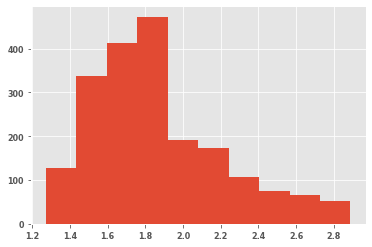

In [131]:
df = res[res.hx_depression==0]
print(np.mean(df.p))
plt.hist(df.OR)

In [65]:
i, len(ds_plot)

(3, 8)

In [51]:
axs.ravel()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

In [42]:
set(start12_end15_5yfu.opioid_rx_enroll)

{10, 15}

(720, 33)


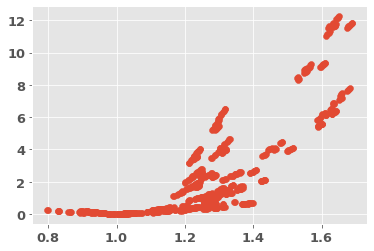

In [92]:
dep_anx = allexpts[(allexpts.hx_depression==1) & (allexpts.hx_anxiety==1) ]
print(dep_anx.shape)
plt.scatter(dep_anx.OR, -np.log10(dep_anx.bh_p))

In [93]:
Counter(dep_anx[dep_anx.bh_p>=0.05].start_enroll)

Counter({2006: 288, 2009: 100, 2012: 6})

(240, 33)


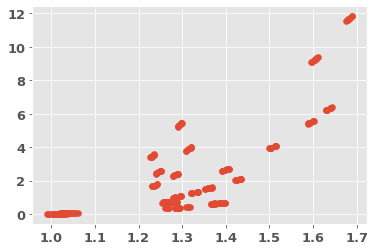

In [87]:
dep_anx = allexpts[(allexpts.hx_depression==1) & (allexpts.hx_anxiety==1) & (allexpts.hx_sud_covar==1)]
print(dep_anx.shape)
plt.scatter(dep_anx.OR, -np.log10(dep_anx.bh_p))

In [81]:
start06_end09_5yfu = res[(res.start_enroll==2006) & (res.followup_time==5)]
start06_end09_10yfu = res[(res.start_enroll==2006) & (res.followup_time==10)]
start09_end12_5yfu = res[(res.start_enroll==2009) & (res.followup_time==5)]
start09_end12_10yfu = res[(res.start_enroll==2009) & (res.followup_time==10)]
start12_end15_5yfu = res[(res.start_enroll==2012) & (res.followup_time==5)]

df = start09_end12_10yfu

five = df[(df['opioid_rx_enroll']==5)]
ten = df[(df['opioid_rx_enroll']==10)]  
fifteen = df[(df['opioid_rx_enroll']==15)]

print(np.mean(five.control_N), np.mean(ten.control_N), np.mean(fifteen.control_N),
      np.mean(five.opioid_N), np.mean(ten.opioid_N), np.mean(fifteen.opioid_N))

94375.0 94375.0 94375.0 7035.0 3569.0 2235.0


/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0.5, 0, 'Vibration number')

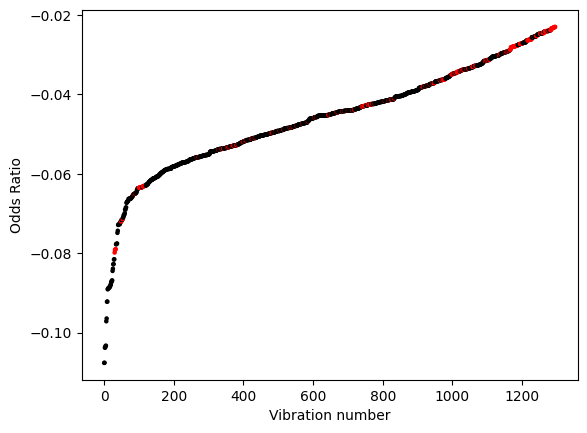

In [26]:
plt.style.use('default')
df['color'] = 'black'
df['color'].loc[df['bh_p'] >= 0.05] = 'red'
# df['color'].loc[(df['bh_p'] < 0.05) & (df['hx_hiv']==0) & (df['hx_sickle']==0)] = 'yellow'

df.sort_values(by='coef',inplace=True)

# plt.errorbar(range(len(df.coef)),df.coef, yerr=df['stderr'],alpha=0.02,color='grey')#'#E7E7E7')
plt.scatter(range(len(df.coef)),df.coef, color=df.color, s=5)
plt.ylabel('Odds Ratio')
plt.xlabel('Vibration number')

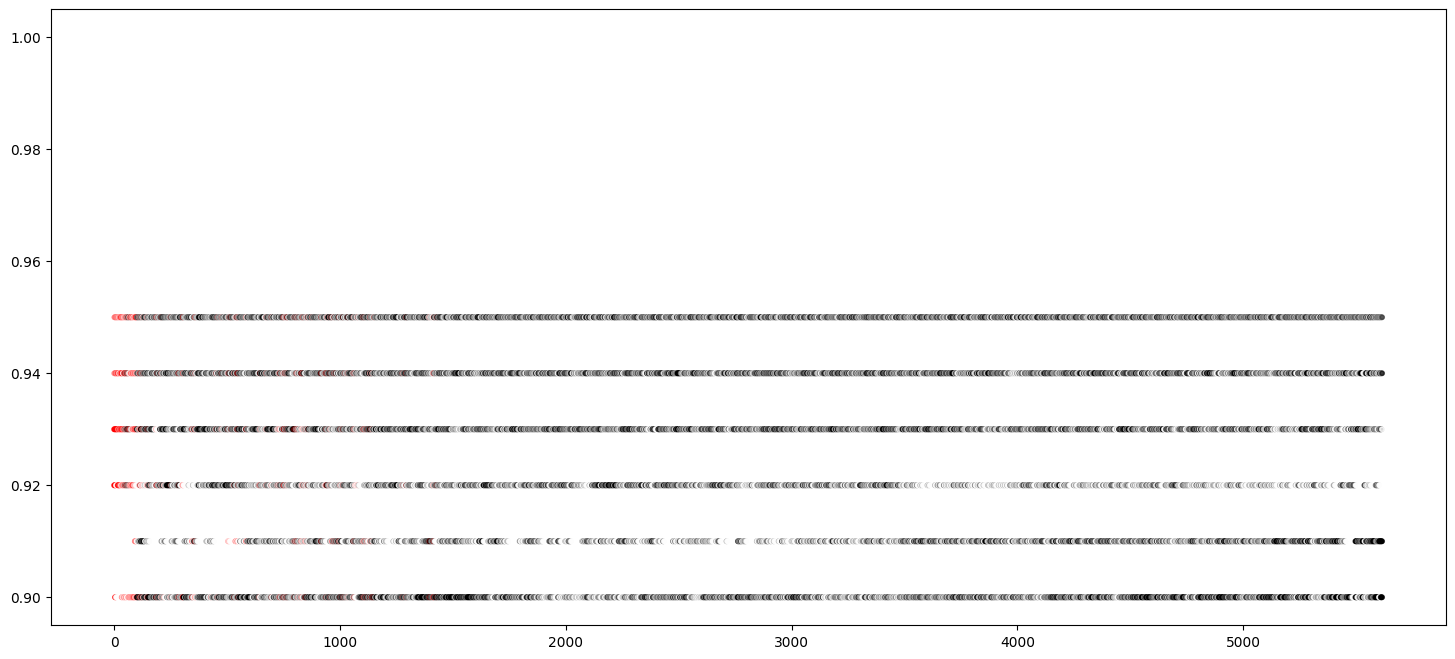

In [69]:
import seaborn as sns

dashboard = df.loc[:,['followup_time','start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hepc', 'hx_hiv', 'hx_aud', 'hx_sud_covar', 'hx_MAT','color']]


plt.figure(figsize=(18, 8))
ytick=1
for col in dashboard.columns[:-1]:
    dashboard[f'{col}_color'] = 'white'
    dashboard[f'{col}_color'].loc[dashboard[col]==1] = 'black'
    dashboard[f'{col}_color'].loc[(dashboard['color']=='red') & (dashboard[col]==1)] = 'red'
    plt.scatter(range(dashboard.shape[0]), [ytick]*dashboard.shape[0],s=10,alpha=0.4,color=dashboard[f'{col}_color'])
    ytick-=0.01
# sns.swarmplot('index', 'hx_sud_covar', data=db)

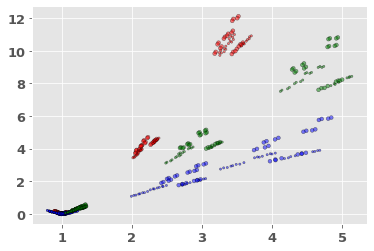

In [82]:
r=start06_end09_5yfu
# noCon = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0)]
# conSud = r[(r['hx_sud_covar']==1) & (r['hx_aud']==0)]    
# conAud = r[(r['hx_sud_covar']==0) & (r['hx_aud']==1)]

noCon = r[(r['opioid_rx_enroll']==5)]
conSud = r[(r['opioid_rx_enroll']==10)]  
conAud = r[(r['opioid_rx_enroll']==15)]

p1 = plt.scatter(noCon.OR, -np.log10(noCon[p_col]), c='red',
                    s=noCon['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='Neither'#5
                          )
#Control AUD only
p2 = plt.scatter(conAud.OR, -np.log10(conAud[p_col]), c='blue',
                s=conAud['markerscale'].values, 
                       edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                label='AUD'#10#
                      )
#Control SUD only
p3 = plt.scatter(conSud.OR, -np.log10(conSud[p_col]), c='green',
                s=conSud['markerscale'].values, 
                       edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                label='SUD'#15#
                      )

(288, 33) 0.3125 (288, 33) 0.8194444444444444 (288, 33) 1.0
50% OR: 1.17560302990963
50% p: 0.2624695098206623
mean control age: 64.32295482512804
mean opioid age: 64.83035854265053


[1.55599503 1.62222387 2.29147142 2.33924925 2.36939148 2.40961681
 2.55532252 2.62978329 2.83426699 2.87391208 2.91918622 2.94339839
 2.94908427 3.03677794 3.04849865 3.2198226  3.22619371 3.59572331
 3.62264096 3.62743355 3.67804424 3.73698542 3.95933026 4.04266674
 4.09232955 4.15905047 4.20720567 4.23127225 4.23647359 4.24185829
 4.34033542 4.40735352 4.4903497  4.51921562 4.61410349 4.70883563
 4.71101558 4.75233367 4.77423017 4.78042522 4.82818096 4.84300889
 4.85340663 4.88200517 4.92974452 4.93551877 4.95239407 4.95520562
 4.97583016 5.13094467 5.17965572 5.37439653 5.47608715 5.52147328
 5.57289833 5.58073899 5.58300466 5.58481628 5.64026089 5.66578502
 5.77588317 5.83144585 5.86818131 5.89080904 5.91708925 5.95726327
 6.00379613 6.05084336 6.06759231 6.07761144 6.1105633  6.63041022
 7.15389577 

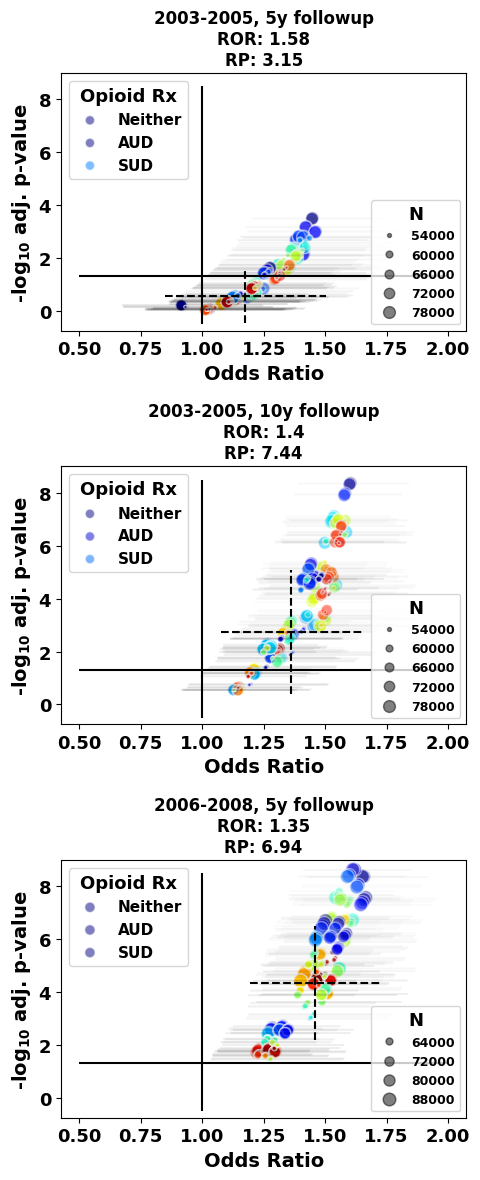

In [33]:
#### density 

#plot and color based on follow-up time and controlling for SUD

#Three plots:
#2003-2005, 5y followup
#2003-2005, 10y followup
#2006-2008, 5y followup
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,12))

#min-max scale marker size based on total N of experiments for plotting and legend
markermin = 5
markermax = 100
res['markerscale'] = (markermax-markermin) * ((res['total_N'] - min(res['total_N'])) / \
                                               (max(res['total_N']) - min(res['total_N']))) + markermin
alpha=0.5
edgecolor='white'
p_col = 'bh_p'
        
res1 = res[(res.start_enroll==2003) & (res.followup_time==5)]
res2 = res[(res.start_enroll==2003) & (res.followup_time==10)]
res3 = res[res.start_enroll==2006]

print(res1.shape, res1[(res1[p_col]<0.05) & (res1.OR>1)].shape[0] / res1.shape[0],
     res2.shape, res2[(res2[p_col]<0.05) & (res2.OR>1)].shape[0] / res2.shape[0],
     res3.shape, res3[(res3[p_col]<0.05) & (res3.OR>1)].shape[0] / res3.shape[0])


def plot_results(r, panel, fu):
    from scipy.stats import gaussian_kde

    ax[panel].hlines(-np.log10(0.05),xmin=0.5, xmax=2, color='black')
    ax[panel].vlines(1.0, ymin=-0.5, ymax=8.5, color='black')

    noCon = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0)]
    conSud = r[(r['hx_sud_covar']==1) & (r['hx_aud']==0)]
    conAud = r[(r['hx_sud_covar']==0) & (r['hx_aud']==1)]

    
    

    
    print(f'50% OR: {np.median(r.OR)}')
    print(f'50% p: {np.median(r.bh_p)}')
    print(f'mean control age: {np.mean(r.control_AgeMean)}')
    print(f'mean opioid age: {np.mean(r.opioid_AgeMean)}')
    print('\n')

#     noCon = r[(r['opioid_rx_enroll']==5)]
#     conAud = r[(r['opioid_rx_enroll']==10) ]
#     conSud = r[(r['opioid_rx_enroll']==15) ]

    
    # Calculate the point density
    x = noCon.OR.values;y = -np.log10(noCon[p_col].values)
    xy = np.vstack([x,y]); z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    print(z)
    p1 = ax[panel].scatter(x, y, c=z,
                    s=noCon['markerscale'].values, 
                           edgecolor=edgecolor, cmap=plt.cm.jet, alpha=alpha,
                    label='Neither'#5
                          )
    
    x = conAud.OR.values;y = -np.log10(conAud[p_col].values)
    xy = np.vstack([x,y]); z = gaussian_kde(xy)(xy)
    p2 = ax[panel].scatter(x,y, c=z,
                    s=conAud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=plt.cm.jet, alpha=alpha,
                    label='AUD'#10#
                          )
    
    x = conSud.OR.values;y = -np.log10(conSud[p_col].values)
    xy = np.vstack([x,y]); z = gaussian_kde(xy)(xy)
    p3 = ax[panel].scatter(x, y, c=z,
                    s=conSud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=plt.cm.jet, alpha=alpha,
                    label='SUD'#15#
                          )
    
#     legend1 = ax[panel].legend(loc='upper left', title='Controls', prop={'size': 11})
    legend1 = ax[panel].legend(loc='upper left', title='Opioid Rx', prop={'size': 11})

    ax[panel].add_artist(legend1)
    
    ax[panel].set_ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    ax[panel].set_xlabel('Odds Ratio', fontsize=14)
    
    lower_error = abs(r.OR-r['.025'])
    higher_error = abs(r.OR-r['.975'])
    ax[panel].errorbar(r.OR, -np.log10(r[p_col]), xerr=[lower_error, higher_error],
                 alpha=0.2, color='k', linewidth=0.1, ls='none')
    
    ax[panel].vlines(np.median(r.OR), ymin=np.median(-np.log10(r[p_col]))-\
                     (0.3*(max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))), 
               ymax=np.median(-np.log10(r[p_col]))+\
                     (0.3*(max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))), linestyles='dashed', color='k')
    
    ax[panel].hlines(np.median(-np.log10(r[p_col])), xmin=np.median(r.OR)-\
                     (0.6*(max(r.OR) - min(r.OR))), 
               xmax=np.median(r.OR)+\
                     (0.6*(max(r.OR) - min(r.OR))), linestyles='dashed', color='k')
    
#     print(np.median(r[p_col]))
    
    
    ors = sorted(r.OR)
    ror = round(ors[int(len(ors)*.99)] / ors[int(len(ors)*.01)],2)
    
    ps = sorted(-np.log10(r.bh_p))
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)
    
    ax[panel].set_title(
        f"{r.start_enroll.values[0]}-{r.end_enroll.values[0]-1}, {fu}y followup\nROR: {ror}\nRP: {rp}",
            size=12)
#     ax[panel].legend(*sc.legend_elements("sizes", num=6))
    
    # produce a legend with a cross section of sizes from the scatter
#     handles, labels = p1.legend_elements(prop="sizes", alpha=0.6)
#     print(handles, labels)
    kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
              func=lambda s: s/(markermax-markermin) * (\
                                                      (max(r['total_N']) - min(r['total_N']))\
                                                    ) - markermin + min(r['total_N']))
    legend2 = ax[panel].legend(*p1.legend_elements(**kw),#handles, labels,
                               loc="lower right", title="N", prop={'size': 9})
    ax[panel].set_ylim((-0.75,9))
#     plt.tight_layout()

plot_results(res1, 0, 5)
plot_results(res2, 1, 10)
plot_results(res3, 2, 5)
    
plt.tight_layout()
# plt.savefig('figures/voe_enrollment_followup_AUD_SUD.png', dpi=600)
# plt.savefig('figures/voe_enrollment_opioidRX.png', dpi=600)

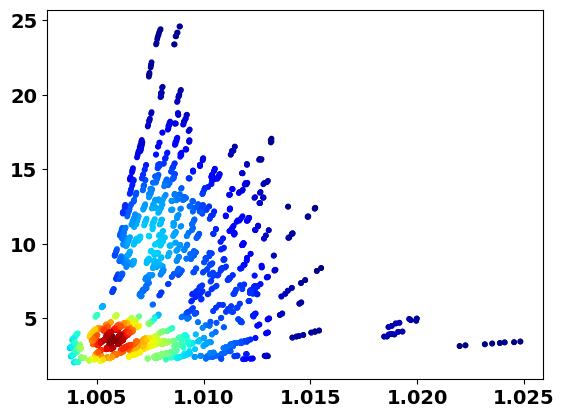

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# set x,y data
x = df.coef
y = -np.log10(df.bh_p)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, cmap=plt.cm.jet,s=10)
plt.show()